<a href="https://colab.research.google.com/github/yesimcebeci/Twitter-Sentiment-Analysis-on-Airlines/blob/main/Preprocessing_and_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
!pip install sklearn
!pip install wordcloud
!pip install bs4
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=2bfa1825b9b4a852b83e47d1bc306b5b7d7a01c44063393fa651f7203def69d4
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=04b22428121b3c28630b3733a4f4dde08497580430f71faf485955ffaad5f82f
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [37]:
# importing necessary libraries for EDA and Cleaning
import pandas as pd
# increasing column width by using pandas display option
# This way we can see all given text
pd.options.display.max_colwidth = 200
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('notebook')

# NLP
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import emoji

# from pywsd.utils import lemmatize_sentence
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Machine Learning Models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "/content/drive/MyDrive/Sentiment Analysis/Tweets.csv"
tweets = pd.read_csv(path)

In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

The US Airline Sentiment dataset has so many features. Among them, in this project I will be working with the **'airline' ,  'text'  and  'airline_sentiment'** features. Here, I will consider **'airline_sentiment'** as our target label for the classifier

The values in the target data are categorical and are 'neutral', 'positive' & 'negative'. For the easy computation, I will replace the 'neutral', 'positive' & 'negative' with 0, 1 & 2 values respectively.

In [7]:
# Drop dublicates if there is any
tweets = tweets.drop_duplicates(subset=["tweet_id"], keep=False) 
tweets.shape

(14330, 15)

In [8]:
# Dropping unnecessary columns
tweets = tweets[['airline','text','airline_sentiment']]
tweets.head()

,airline,text,airline_sentiment
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral
1,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,Virgin America,@VirginAmerica and it's a really big bad thing about it,negative


In [9]:
tweets.isna().sum()

airline              0
text                 0
airline_sentiment    0
dtype: int64

In [10]:
### Change Text to String ###
tweets["text"] = tweets["text"].astype(str)

### Remove neutral sentiment to focus on just the positive and negative sentiment ###
tweets = tweets[tweets["airline_sentiment"] != 'neutral']
tweets.shape

(11295, 3)

In [11]:
#replacing the categorical values of 'airline_sentiment' to numeric values as positive = 1 , negative =0
tweets['airline_sentiment'].replace(('positive', 'negative'), (1, 0), inplace=True)
tweets['airline_sentiment'].value_counts()

0    8992
1    2303
Name: airline_sentiment, dtype: int64

## Text Preprocessing for Sentiment Analysis




In this part we need to do some work:
- we will be removing **tagged airlines** such as @united,
- **lowercasing** text,
- removing **numbers**,
- removing **punctuations**,
- removing **whitespace**,
- removing **emoji**s

In [12]:
tweets[['text']][1000:1020]


,text
1321,"@united just sent you a message on Facebook, how do I follow up a complaint re. Missing clothing out of checked baggage?"
1322,"@united why do I check in online if I still have to wait in line for an hour to ""check in"" at counter? #fuckinlame @naia_miaa"
1323,@united very poor customer service. I WILL think again befor Flight Booking Problems another United flight.
1324,@united an over booked flight to start with and a red eye from lax to bos with no reclining seat.... #lastflightwithyouever
1326,@united an efficient layout at kiosks/bag drop lines would help as there is no definition to space. Additional friendly and helpful staff
1327,"@united - 75% of a plane's passengers boarding in your ""Premier"" groups might be an indication of a broken process."
1329,@united EWR agent Barbara was FABULOUS and an example of CUST. SERV. A pleasure talking to you😊 http://t.co/KMQuLY9g5E
1330,"@united Cancelled Flightled a flight cause the crew needed sleep.But it's totally okay to wake me up at 3am just to let me know it's Cancelled Flightled, again."
1331,"@united changed my last name for my MileagePlus acct on the site in an hour. @BA_USA had me on hold for 20mins, then 5 days &amp; no change yet"
1332,"@united flight landed 13 hours ago, 2 more flights CMH-IAD last night and still no bag..could have driven it from CMH"


In [13]:
df = tweets.copy()

#Removing tagged airlines
df["text"] = df["text"].str.replace("(@+\w+)", "")

#Lowercasing text
df["text"] = df["text"].str.lower()

#Removing numbers
df["text"] = df["text"].str.replace('\d+', '', regex=True)

#Removing punctuations
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

df["text"] = df["text"].apply(lambda x: remove_punc(x))

#Removing Whitespace
df["text"] = df["text"].str.strip()

#Removing emoji
df["text"] = df["text"].apply(lambda x: emoji.demojize(x))


In [14]:
df[['text']][1000:1020]


,text
1321,just sent you a message on facebook how do i follow up a complaint re missing clothing out of checked baggage
1322,why do i check in online if i still have to wait in line for an hour to check in at counter fuckinlame
1323,very poor customer service i will think again befor flight booking problems another united flight
1324,an over booked flight to start with and a red eye from lax to bos with no reclining seat lastflightwithyouever
1326,an efficient layout at kiosksbag drop lines would help as there is no definition to space additional friendly and helpful staff
1327,of a planes passengers boarding in your premier groups might be an indication of a broken process
1329,ewr agent barbara was fabulous and an example of cust serv a pleasure talking to you httptcokmqulyge
1330,cancelled flightled a flight cause the crew needed sleepbut its totally okay to wake me up at am just to let me know its cancelled flightled again
1331,changed my last name for my mileageplus acct on the site in an hour had me on hold for mins then days amp no change yet
1332,flight landed hours ago more flights cmhiad last night and still no bagcould have driven it from cmh


Finally, we do all the basic text cleanings like removal of user name mentions,hashtags, numbers etc using the function below. Next step is  I will keep preprocessing and will create another function. This function will:
- remove **stopwords** , 
- **tokenize** text and 
- **lemmatize** each word

In [15]:
# Creating variable for english stopwords.
stop_words = stopwords.words('english')

In [16]:
def cleaning(data):
    
    #Tokenize
    text_tokens = word_tokenize(data.replace("'", "")) 
    
    #Removing Stopwords
    tokens_without_sw = [t for t in text_tokens if t not in stop_words]  
    
    #lemma
    text_lemma = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    cleaned_text = " ".join(text_lemma)

    return cleaned_text


In [17]:
#Applying function to target
df["text"] = df["text"].apply(cleaning)
df["text"].head()

1                                      plus youve added commercial experience tacky
3    really aggressive blast obnoxious entertainment guest face amp little recourse
4                                                              really big bad thing
5          seriously would pay flight seat didnt playing really bad thing flying va
6                                yes nearly every time fly vx ear worm wont go away
Name: text, dtype: object

- I preffered choose lemmatization instead of stemming, because the purpose of lemmatization is same as that of stemming but overcomes the drawbacks of stemming. In stemming, for some words, it may not give meaningful representation such as “Chang”. Here, lemmatization comes into picture as it gives meaningful word.

- Lemmatization takes more time as compared to stemming because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time.

In [18]:
# Showing which words have the most counts in the all texts within each category.
FreqDist(" ".join(df["text"]).split()).most_common(50)

[('flight', 3684),
 ('get', 1122),
 ('hour', 1096),
 ('cancelled', 921),
 ('service', 910),
 ('thanks', 885),
 ('customer', 880),
 ('u', 877),
 ('time', 827),
 ('bag', 685),
 ('help', 682),
 ('plane', 646),
 ('im', 618),
 ('hold', 605),
 ('amp', 546),
 ('thank', 526),
 ('cant', 515),
 ('still', 513),
 ('call', 508),
 ('day', 500),
 ('delayed', 495),
 ('one', 489),
 ('airline', 488),
 ('gate', 481),
 ('need', 448),
 ('flightled', 438),
 ('back', 436),
 ('dont', 427),
 ('would', 419),
 ('delay', 411),
 ('phone', 406),
 ('hr', 402),
 ('got', 392),
 ('agent', 391),
 ('late', 390),
 ('seat', 389),
 ('please', 373),
 ('guy', 364),
 ('min', 349),
 ('like', 345),
 ('today', 344),
 ('waiting', 343),
 ('minute', 325),
 ('ive', 309),
 ('great', 308),
 ('make', 304),
 ('trying', 299),
 ('wait', 297),
 ('never', 296),
 ('fly', 295)]

In [19]:
# Showing which words have the most counts in the positive texts within each category.

all_positive_text = df.loc[df.airline_sentiment == 1].text.map(word_tokenize).values
all_positive_corpus = [word for text in all_positive_text for word in text]
freq =FreqDist(all_positive_corpus).most_common(50)
# all_positive_df = pd.DataFrame(freq, columns=['Word', 'Frequency'])
# all_positive_df

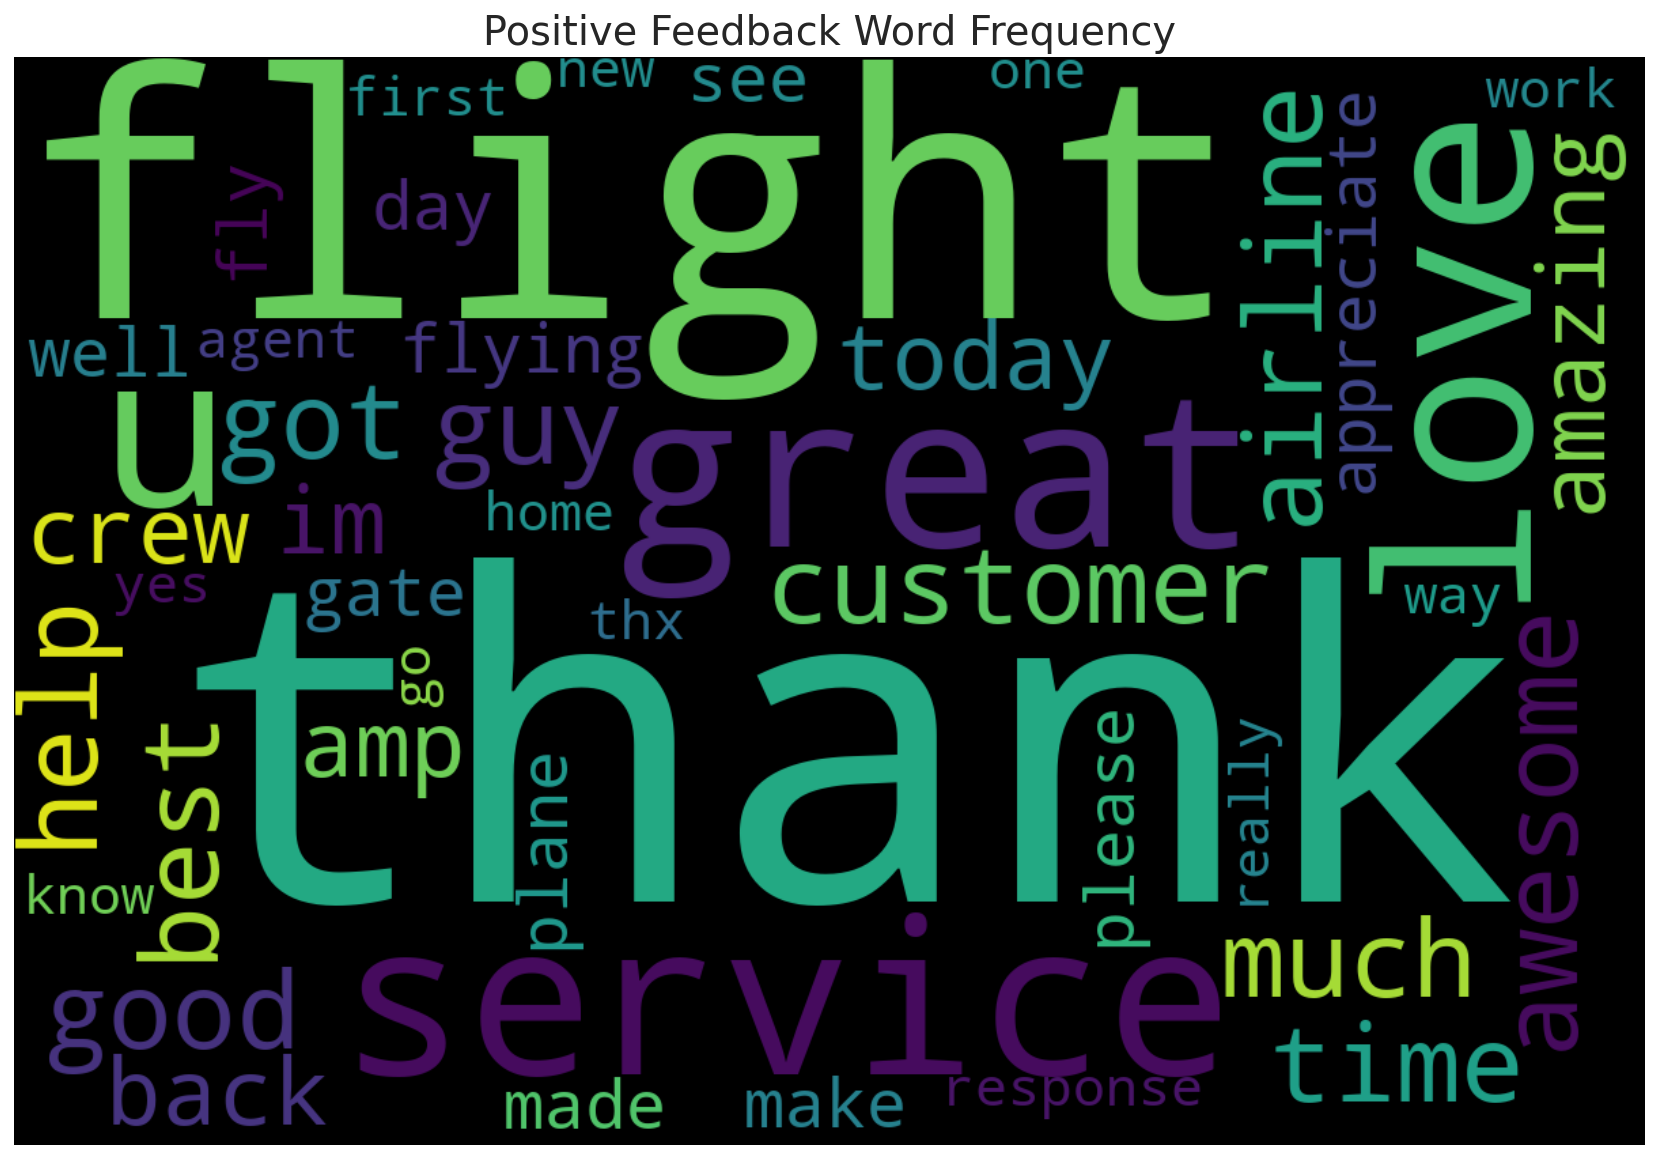

In [20]:
from wordcloud import WordCloud
all_positive_corpus = ' '.join(w[0] for w in freq)
airline_wordcloud = WordCloud(width = 1200, height = 800).generate(all_positive_corpus)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Positive Feedback Word Frequency' , fontsize = 20)
plt.axis("off")
plt.show()

- This bar chart shows us the top 50 most frequent words in positive feedback.The meaningful words that can be spotted in the positive sentiments’ word cloud directly include **“thank”**, **“flight”** and **“great”**. This shows people tend to appreciate the airline on social media when they have positive flight experience

In [21]:
# all_positive_df.set_index('Word')
# all_positive_df.plot.bar(x='Word', y='Frequency', figsize=(20,7))

# # Add title and axis names
# plt.title('Positive Feedback Word Frequency')
# plt.xlabel('Word')
# plt.ylabel('Frequency')
 
# # Show graphic
# plt.show()

In [22]:
# Showing which words have the most counts in the negative texts within each category.

all_negative_text = df.loc[df.airline_sentiment == 0].text.map(word_tokenize).values
all_negative_corpus = [word for text in all_negative_text for word in text]
freq = FreqDist(all_negative_corpus).most_common(50)

# all_negative_df = pd.DataFrame(freq, columns=['Word', 'Frequency'])
# all_negative_df

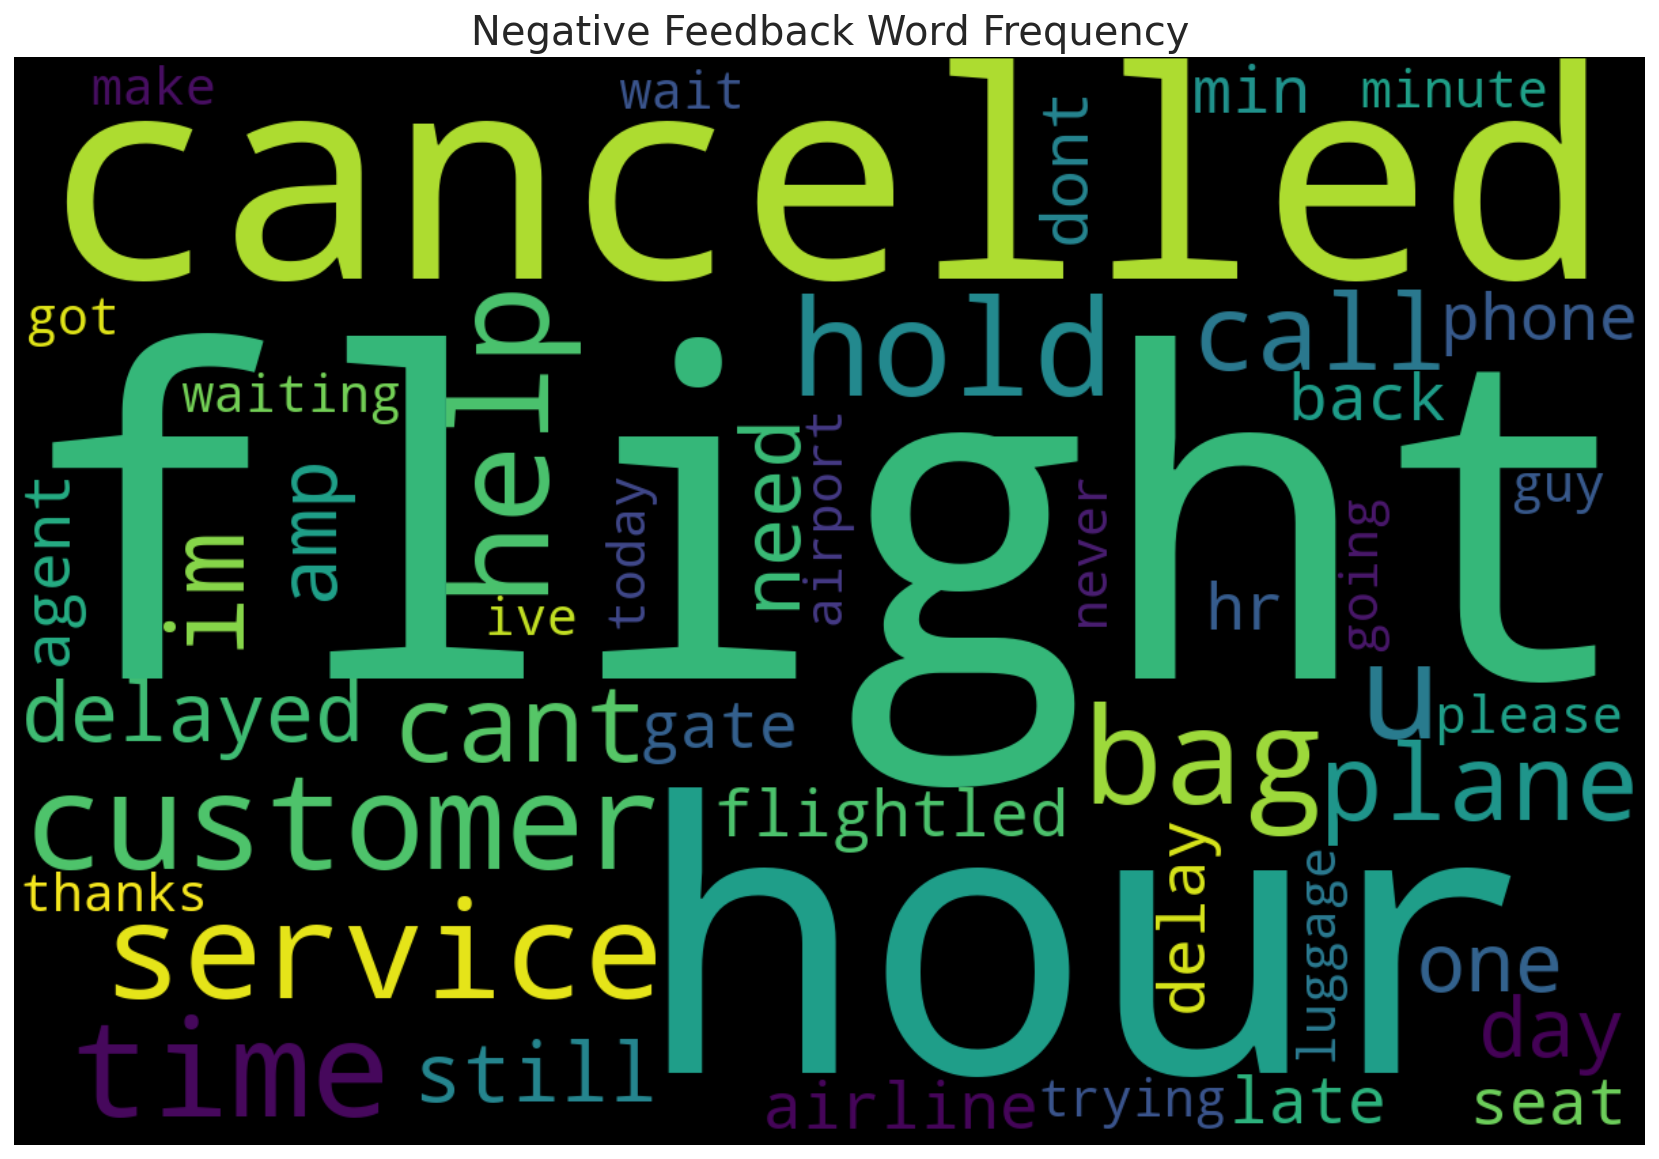

In [23]:
all_negative_corpus = ' '.join(w[0] for w in freq)
airline_wordcloud = WordCloud(width = 1200, height = 800).generate(all_negative_corpus)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Negative Feedback Word Frequency' , fontsize = 20)
plt.axis("off")
plt.show()

In [24]:
# all_negative_df.set_index('Word')
# all_negative_df.plot.bar(x='Word', y='Frequency', figsize=(20,7))

# # Add title and axis names
# plt.title('negative Feedback Word Frequency')
# plt.xlabel('Word')
# plt.ylabel('Frequency')
 
# # Show graphic
# plt.show()

- We observe from the word cloud that tweets related to **“cancelled”** are causing the most negative tweets. And also  **"Flight"**, **"hour"**, **"delayed"** have higher frequencies than other words.
- Also, **"cancelled"** shows that flight cancellation maybe the most important reason why customers are showing their negative feedback on Twitter.
- Other complaints were related to **customer service**,**layover**, **bag** **hold ** and **call** as seen in the word cloud.



## Model Preparation

**Comment here!**
<!-- **Prepare feature and label for generic tweet for sentimental prediction using TfidfVectorizer**
Count vectorizer is used over IF-IDF vectorizer when preparing the model because IF-IDF vectorizer reduces the impact of words that are common through the document. However, in our case here some common word such as 'cancel' or 'delay' is crucial to determine the sentiment of text message. The count vectorizer is trained based on the generic tweet vocabulary, and only top 2000 words are selected as feature for sake of efficiency and avoiding model overfitting. -->

In [25]:
# Spliting data into train and test 
X = df["text"]
y = df["airline_sentiment"]

# Train-test split on data. The train set size is 75% of the whole data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
                                                                   

### Vectorization

Now we can make use of **TfidfVectorizer** and **CountVectorizer**  transfer Tweet contents into vectors, in order to train the model.

So , What Is The Difference Between **TfidfVectorizer** and **CountVectorizer** ?

TF-IDF Vectorizer and Count Vectorizer are both methods used in natural language processing to vectorize text. However, there is a fundamental difference between the two methods.

- **CountVectorizer** simply counts the number of times a word appears in a document (using a bag-of-words approach).

-  **TF-IDF Vectorizer** takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. Now we will be building predictive models on the dataset using the two feature set **CountVectorizer** and **TF-IDF**.

Then we will use logistic regression classifier as baseline model to predict the overall sentiment of future tweets

In [26]:
 # The purpose of max_features is to limit the number of features(words) from the dataset
tfidf = TfidfVectorizer(max_features=10)
cv = CountVectorizer(max_features=10)

### Get Base Model with Logistic Regression

Whenever you test a machine learning method, it’s helpful to have a baseline method and accuracy level against which to measure improvements. In the field of sentiment analysis, one model works particularly well and is easy to set up, making it the ideal baseline for comparison.

In [29]:
# building pipelines without tuning
lr_tf =  Pipeline([('tfidf', tfidf), ('Logistic Regression', LogisticRegression(random_state = 42))])
lr_cv =  Pipeline([('cv', cv), ('Logistic Regression', LogisticRegression(random_state = 42))])

models = [('Logistic Regression tfidf', lr_tf),
          ('Logistic Regression cv', lr_cv)]

In [30]:
# Validation scores
[(name, cross_val_score(model, X_train, y_train, cv=5).mean()) for name, model in models]


[('Logistic Regression tfidf', 0.8243417510352347),
 ('Logistic Regression cv', 0.825522318925376)]

In [31]:
# Accuracy scores using test data from train-test split
def accuracy(model):
    model.fit(X_train, y_train)
    pred_y = model.predict(X_test)
    return accuracy_score(y_test, pred_y)


In [32]:
[(name, accuracy(model)) for name, model in models]


[('Logistic Regression tfidf', 0.8268413597733711),
 ('Logistic Regression cv', 0.8261331444759207)]

In [33]:
#Creating function to evaluate our models.
def evaluation(model, X_train, X_test):
    
    """ This function created for visualization and resul to see train and test both sets results."""
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print("==== Train Set ====")
    
    print(classification_report(y_train,y_pred_train))
    
    print("==== Test Set ====")
    
    print(classification_report(y_test,y_pred))
    plot_confusion_matrix(model,X_test, y_test)
    plt.grid(None)
    

==== Train Set ====
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      6722
           1       0.76      0.22      0.34      1749

    accuracy                           0.82      8471
   macro avg       0.79      0.60      0.62      8471
weighted avg       0.81      0.82      0.78      8471

==== Test Set ====
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      2270
           1       0.69      0.22      0.33       554

    accuracy                           0.83      2824
   macro avg       0.76      0.60      0.61      2824
weighted avg       0.81      0.83      0.79      2824

==== Train Set ====
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      6722
           1       0.74      0.24      0.36      1749

    accuracy                           0.83      8471
   macro avg       0.79      0.61      0.63      8471
weighted avg   

[('Logistic Regression tfidf', None), ('Logistic Regression cv', None)]

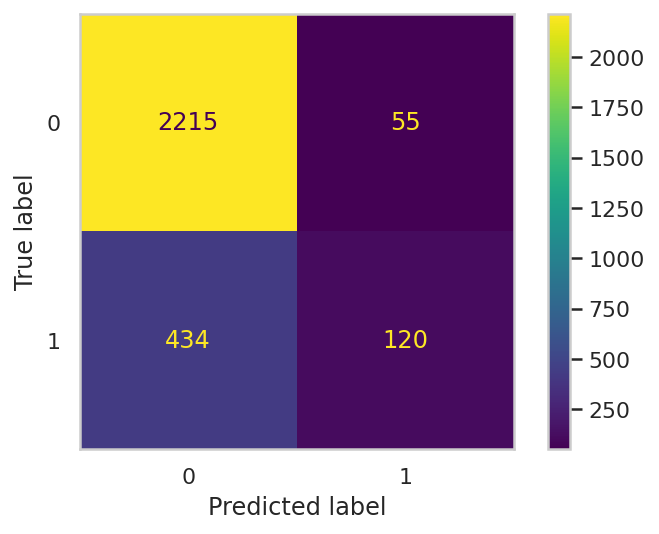

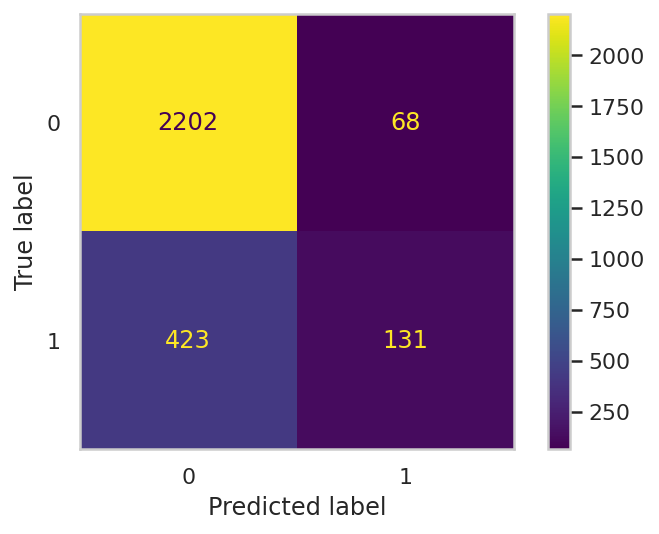

In [38]:
[(name, evaluation(model,X_train, X_test)) for name, model in models]


**Comment!**<!-- The confusion matrix is an N x N matrix, that is used to evaluate the performance of a
machine learning classification model, N represent the output classes number. The matrix
cross check how the model been able to correctly classify each output correctly or not.
Moreover, then we can observe certain metrics from the matrix such as accuracy, which
can let us know how good is the model. -->

COmment!<!-- An effective machine learning model was built by training, testing,
and evaluating Support Vector Classifiers along with FastText embeddings. After several
steps of cleaning and pre-processing, Linear SVC gave a weighted average f1 score of
84%.
Since the sentiments clearly differs by the days of the week, the airline industry may have
to consider business decisions which take this analysis into account. For example, having
a varied work force of customer service representatives depending on the day of the week
may prove beneficial. Digging deeper down into the causes of negative sentiments may
also reveal some pain points, helping the airline industry in forming a plan of action to
mitigate these issues. -->

Comment!
<!-- 5.2 Recommendations and Future Work
More data can be scraped from Twitter using the third-party scraping tool and more
machine learning models can be tested.
To crystallize the analysis, all one has to do is take airline tweets from a larger duration
of choice and use this same approach of tagging the tweets, training using machine
learning models and predict the sentiments using our model. Further statistical analysis
can be done to check the correlation between the sentiment with the day of the week. -->